<a href="https://colab.research.google.com/github/vkthakur90/Econometrics/blob/main/Autoregressive_Stock_Price_prediction_using_Direct_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Positional Trading with Auto Regression Finite Horizon Forecast

## Abstract
In this study, we propose a method for forecasting stock price returns using an autoregressive (AR) model with a finite forecast horizon. The methodology leverages linear algebra to estimate model parameters via the least squares method, and then applies Monte Carlo simulations to assess forecast uncertainty.

## Methodology
Let $ S_t $ be the stock price at time $ t $. The log-return is defined as:

\begin{equation}
r_t = \log(S_t) - \log(S_{t-1})
\end{equation}

These returns are standardized to obtain:

\begin{equation}
x_t = \frac{r_t - \mu_r}{\sigma_r}
\end{equation}


where $ \mu_r $ and $ \sigma_r $ are the mean and standard deviation of $ r_t $ respectively.

An autoregressive model of order \( p \) is assumed for the standardized returns:

\begin{equation}
x_t = \sum_{i=1}^{p} \phi_i x_{t-i} + \epsilon_t,
\end{equation}

with \(\epsilon_t\) representing the error term. The model parameters \( \phi_i \) are estimated by solving the normal equations:

\begin{equation}
\hat{\Phi} = \left( X^T X \right)^{-1} X^T Y,
\end{equation}

where $ X $ is the matrix of lagged features and $ Y $  is the matrix of future standardized returns over the forecast horizon $  h $ .

Forecast uncertainty is evaluated by generating multiple Monte Carlo simulation paths. Each simulation incorporates both the estimated parameter uncertainty and the stochastic error term drawn from a t-distribution and normal distribution combination. The simulated paths are transformed back to price forecasts using cumulative summation and exponentiation.

## Implementation Overview
- **Data Download and Preprocessing:** Retrieve historical stock data and compute log returns.
- **Feature Engineering:** Generate lagged features for training the AR model and for the forecast.
- **Model Fitting:** Estimate the AR model parameters using linear algebra operations.
- **Forecasting:** Use Monte Carlo simulations to produce forecast paths and compute risk quantiles.
- **Visualization:** Plot historical data, forecast paths, and risk metrics.


In [1]:
"""
Positional Trading with Auto Regression Finite Horizon Forecast
----------------------------------------------------------------
This script downloads stock data, computes log returns, fits an autoregressive
model using linear algebra, and produces Monte Carlo forecasts over a finite horizon.
It also visualizes the forecasts and risk quantiles.

Author: Vinay Kumar Thakur
Date: Tuesday, March 19, 2025
"""

# Import necessary libraries
import yfinance as yf                   # For downloading stock market data
import numpy as np                      # For numerical operations
import pandas as pd                     # For data manipulation
import matplotlib.pyplot as plt         # For plotting graphs
import scipy.linalg as la               # For linear algebra operations
import seaborn as sns                   # For enhanced visualizations
from datetime import datetime, timedelta
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

In [2]:
# Set the ticker symbol and autoregressive model parameters
ticker = 'LICI.NS'  # Stock ticker symbol
ar_p = 200          # Number of lagged observations (autoregressive order)
ar_h = 100          # Forecast horizon (number of future time steps to predict)

# Monte Carlo simulation settings
num_paths = 10000   # Number of Monte Carlo simulation paths
paths_to_plot = 5   # Number of simulation paths to plot

In [3]:
def download_data(entity, ticker):
    """
    Download historical stock data using yfinance.

    Parameters:
        entity (dict): A dictionary to store data.
        ticker (str): Stock ticker symbol.

    The data is downloaded for the past 5 years at a 1-day interval.
    Timezone adjustments are performed to localize to Asia/Kolkata.
    """
    print(f"Downloading {ticker}")
    data = yf.download(ticker, period="5y", interval="1d")

    # Localize timezone if not already localized
    if data.index.tzinfo is None:
        data.index = data.index.tz_localize('UTC')

    # Convert timezone to Asia/Kolkata
    data.index = data.index.tz_convert('Asia/Kolkata')

    # Create a DataFrame with the closing prices
    data_ = pd.DataFrame({
        'S': data['Close'].values.reshape((-1,))
    }, index=data.index)

    entity['data'] = data_

In [4]:
def calculate_return(entity):
    """
    Calculate the log return for the stock prices.

    Adds two new columns:
      - 'log_S': Natural logarithm of the closing prices.
      - 'r': Log returns computed as the difference of log_S.
    """
    data = entity['data']
    data.eval('log_S = log(S)', inplace=True)  # Compute log of closing prices
    data['r'] = data['log_S'].diff()            # Calculate log returns

In [5]:
def split_data(entity):
    """
    Split the data into training and testing sets.

    Training data: All data except the last 'ar_h' observations.
    Testing data: The last 'ar_h' observations.
    """
    entity['train'] = entity['data'].iloc[:-ar_h]
    entity['test'] = entity['data'].iloc[-ar_h:]

In [6]:
def train_feature_engg(entity):
    """
    Generate features for training the autoregressive model.

    Constructs:
      - Lagged features: 'x_m1', 'x_m2', ..., 'x_m{ar_p}'
      - Future (lead) features: 'x_p0', 'x_p1', ..., 'x_p{ar_h - 1}'

    Standardizes the returns 'r' to form a new feature 'x'.
    """
    data = entity['train']
    features_df = data[['S', 'r']].copy()

    # Standardize returns: subtract mean and divide by std deviation
    features_df['x'] = (features_df['r'] - features_df['r'].mean()) / features_df['r'].std()

    # Create lagged features for autoregression
    for idx in range(ar_p):
        features_df[f'x_m{idx + 1}'] = features_df['x'].shift(idx + 1)

    # Create future features for forecasting
    for idx in range(ar_h):
        features_df[f'x_p{idx}'] = features_df['x'].shift(-idx)

    # Remove rows with missing values due to shifting
    features_df.dropna(inplace=True)

    # Store the features DataFrame
    entity['features'] = features_df
    entity['features_train_x'] = features_df[[f'x_m{idx + 1}' for idx in range(ar_p)]]
    entity['features_train_y'] = features_df[[f'x_p{idx}' for idx in range(ar_h)]]


In [7]:
def forecast_feature_engg(entity):
    """
    Generate features for forecasting using the entire dataset.

    Similar to the training feature engineering but uses the full data.
    """
    data = entity['data']
    features_df = data[['S', 'r']].copy()

    # Standardize returns for forecasting
    features_df['x'] = (features_df['r'] - features_df['r'].mean()) / features_df['r'].std()

    # Create lagged features for forecasting
    for idx in range(ar_p):
        features_df[f'x_m{idx + 1}'] = features_df['x'].shift(idx + 1)

    # Create future features for forecasting
    for idx in range(ar_h):
        features_df[f'x_p{idx}'] = features_df['x'].shift(-idx)

    # Drop rows with missing values
    features_df.dropna(inplace=True)

    # Store forecast features in the entity dictionary
    entity['features_forecast'] = features_df
    entity['features_forecast_x'] = features_df[[f'x_m{idx + 1}' for idx in range(ar_p)]]
    entity['features_forecast_y'] = features_df[[f'x_p{idx}' for idx in range(ar_h)]]

In [8]:
def fit_model(entity):
    """
    Fit the autoregressive model on training data.

    The estimation uses the least squares approach:
      weights = (X^T X)^{-1} X^T Y

    Also computes the intercept and residual standard deviation (sigma).
    """
    # Center the training feature matrices
    delta_x = entity['features_train_x'] - entity['features_train_x'].mean()
    delta_y = entity['features_train_y'] - entity['features_train_y'].mean()

    # Compute normal equation components
    A = np.matmul(delta_x.T, delta_x)
    b = np.matmul(delta_x.T, delta_y)

    # Compute inverse of A using linear algebra
    inv_A = pd.DataFrame(la.inv(A), columns=entity['features_train_x'].columns, index=entity['features_train_x'].columns)

    # Calculate weights (model parameters)
    weights = np.matmul(inv_A, b)

    # Calculate the intercept using the mean of x and y
    mean_x = pd.DataFrame({'Intercept': entity['features_train_x'].mean()}).T
    mean_y = pd.DataFrame({'Intercept': entity['features_train_y'].mean()}).T
    intercept = mean_y - np.matmul(mean_x, weights)

    # Compute residuals from the fitted model
    residue = entity['features_train_y'] - np.matmul(entity['features_train_x'], weights)

    # Degrees of freedom for sigma calculation
    dof = len(entity['features_train_x']) - len(weights) - 1
    sigma_df = pd.DataFrame({'sigma': np.sqrt((residue**2).sum() / dof)})

    # Store all parameters in the entity dictionary
    entity['params'] = pd.concat([intercept, weights, sigma_df.T])

In [9]:
def fit_forecast_model(entity):
    """
    Fit the autoregressive model on forecast features.

    Similar to the training model fit, but uses features generated for forecasting.
    """
    # Center the forecast feature matrices
    delta_x = entity['features_forecast_x'] - entity['features_forecast_x'].mean()
    delta_y = entity['features_forecast_y'] - entity['features_forecast_y'].mean()

    # Compute components for the normal equation
    A = np.matmul(delta_x.T, delta_x)
    b = np.matmul(delta_x.T, delta_y)

    # Calculate weights using the inverse of A
    inv_A = pd.DataFrame(la.inv(A), columns=entity['features_forecast_x'].columns, index=entity['features_forecast_x'].columns)
    weights = np.matmul(inv_A, b)

    # Compute the intercept for the forecast model
    mean_x = pd.DataFrame({'Intercept': entity['features_forecast_x'].mean()}).T
    mean_y = pd.DataFrame({'Intercept': entity['features_forecast_y'].mean()}).T
    intercept = mean_y - np.matmul(mean_x, weights)

    # Calculate residuals for forecast model
    residue = entity['features_forecast_y'] - np.matmul(entity['features_forecast_x'], weights)

    # Degrees of freedom for error variance
    dof = len(entity['features_forecast_x']) - len(weights) - 1
    sigma_df = pd.DataFrame({'sigma': np.sqrt((residue**2).sum() / dof)})

    # Store the forecast parameters
    entity['forecast_params'] = pd.concat([intercept, weights, sigma_df.T])

In [10]:
def test_forecast(entity):
    """
    Perform a test forecast using the training data.

    Generates Monte Carlo simulation paths for the test period and computes:
      - Forecasted returns
      - Forecasted prices (by exponentiating cumulative returns)
      - Monte Carlo quantiles for risk estimation
    """
    # Use the last row of training features as input for forecasting
    pred_input_df = entity['features_train_x'].iloc[-1:]
    delta_pred_x = pred_input_df - entity['features_train_x'].mean()

    # Compute the covariance matrix and its inverse for prediction variance
    cov = entity['features_train_x'].cov()
    inv_cov = pd.DataFrame(la.inv(cov), columns=cov.columns, index=cov.index)

    N = len(entity['features_train_x'])
    # Compute mean variance coefficient and its square root for scaling sigma
    mean_var_coeff = (1 + delta_pred_x @ inv_cov @ delta_pred_x.T) / N
    pred_var_coeff = 1 + mean_var_coeff
    sigma_coeff = pred_var_coeff.apply(np.sqrt).iloc[0, 0]

    # Generate replicated mean and sigma vectors for Monte Carlo paths
    mean = pd.concat([np.matmul(pred_input_df, entity['params'].iloc[1:-1]) + entity['params'].iloc[0]] * num_paths)
    sigma = pd.concat([entity['params'].iloc[-1:]] * num_paths)

    # Degrees of freedom for the error term
    dof = len(entity['features_train_x']) - len(entity['params'].iloc[:-1])

    # Generate random errors from t-distribution and standard normal
    standard_t_df = pd.DataFrame(
        data=np.random.standard_t(df=dof, size=(num_paths, ar_h)),
        columns=entity['params'].columns
    )


    # Create an index for Monte Carlo paths
    mcp_index = [f'mcp_{idx + 1}' for idx in range(num_paths)]
    standard_t_df.index = mcp_index
    mean.index = mcp_index
    sigma.index = mcp_index

    # Generate forecast outputs for returns
    forecast_output_df = mean + sigma_coeff * sigma * standard_t_df
    entity['test_forecast_x'] = forecast_output_df

    # Transform the forecasted standardized returns back to original scale
    entity['test_forecast'] = entity['test_forecast_x'] * entity['train']['r'].std() + entity['train']['r'].mean()
    entity['test_forecast'].columns = entity['test'].index
    entity['test_forecast'].index = [f'paths_{idx + 1}' for idx in range(num_paths)]
    entity['test_forecast'] = entity['test_forecast'].T

    # Initialize forecast price with the last training price
    init_S_df = entity['train'].iloc[-1:][['S']]
    init_forecast_df = pd.DataFrame(np.zeros_like(entity['test_forecast'].iloc[:1]),
                                    columns=entity['test_forecast'].columns, index=init_S_df.index)
    # Compute forecasted prices by cumulatively summing returns and applying exponentiation
    entity['test_forecast'] = pd.concat([init_forecast_df, entity['test_forecast']])
    entity['test_forecast_price'] = init_S_df.iloc[0, 0] * entity['test_forecast'].cumsum().apply(np.exp)

    # Compute risk quantiles from the Monte Carlo simulations
    entity['test_monte_carlo_quantiles'] = entity['test_forecast_price'].quantile([0.025, 0.25, 0.50, 0.75, 0.975], axis=1).T
    entity['test_monte_carlo_quantiles'].columns = ['low_ci', 'quart_1st', 'median', 'quart_3rd', 'high_ci']

In [11]:
def forecast(entity):
    """
    Perform the forecast using the full dataset.

    This function:
      - Prepares the forecast input from the last (ar_p+1) observations.
      - Computes the prediction variance.
      - Generates Monte Carlo paths for future returns.
      - Converts the simulated returns to price forecasts.
      - Computes quantiles for risk assessment.
    """
    # Prepare forecast input by standardizing the last (ar_p+1) returns
    forecast_input_df = pd.DataFrame({
        'x': (entity['data'].iloc[-(ar_p + 1):]['r'] - entity['data']['r'].mean()) / entity['data']['r'].std()
    })

    # Create lagged features for forecasting
    for idx in range(ar_p):
        forecast_input_df[f'x_m{idx + 1}'] = forecast_input_df['x'].shift(idx + 1)

    forecast_input_df.drop('x', axis=1, inplace=True)
    forecast_input_df.dropna(inplace=True)

    # Calculate prediction variance based on the forecast features
    delta_pred_x = forecast_input_df - entity['features_forecast_x'].mean()
    cov = entity['features_forecast_x'].cov()
    inv_cov = pd.DataFrame(la.inv(cov), columns=cov.columns, index=cov.index)
    N = len(entity['features_forecast_x'])
    mean_var_coeff = (1 + delta_pred_x @ inv_cov @ delta_pred_x.T) / N

    pred_var_coeff = 1 + mean_var_coeff
    sigma_coeff = pred_var_coeff.apply(np.sqrt).iloc[0, 0]

    # Generate replicated mean and sigma for Monte Carlo simulation
    mean = pd.concat([np.matmul(entity['features_forecast_x'].iloc[-1:], entity['forecast_params'].iloc[1:-1]) + entity['forecast_params'].iloc[0]] * num_paths)
    sigma = pd.concat([entity['params'].iloc[-1:]] * num_paths)
    dof = len(entity['features_forecast_x']) - len(entity['forecast_params'].iloc[:-1])

    # Generate random errors for the forecast simulation
    standard_t_df = pd.DataFrame(
        data=np.random.standard_t(df=dof, size=(num_paths, ar_h)),
        columns=entity['forecast_params'].columns
    )

    mcp_index = [f'mcp_{idx + 1}' for idx in range(num_paths)]
    standard_t_df.index = mcp_index
    mean.index = mcp_index
    sigma.index = mcp_index

    # Generate simulated future returns
    forecast_output_df = mean + sigma_coeff * sigma * standard_t_df
    entity['forecast_x'] = forecast_output_df

    # Transform forecast returns back to original scale
    entity['forecast'] = entity['forecast_x'] * entity['data']['r'].std() + entity['data']['r'].mean()
    entity['forecast'].index = [f'paths_{idx + 1}' for idx in range(num_paths)]
    entity['forecast'] = entity['forecast'].T

    # Initialize forecast price using the last observed price
    init_S_df = entity['data'].iloc[-1:][['S']]
    init_forecast_df = pd.DataFrame(np.zeros_like(entity['forecast'].iloc[:1]),
                                    columns=entity['forecast'].columns, index=init_S_df.index)
    entity['forecast'] = pd.concat([init_forecast_df, entity['forecast']])

    # Set forecast dates and compute forecasted prices
    entity['forecast'].index = pd.date_range(start=init_S_df.index[0], periods=len(entity['forecast']), freq='B')
    entity['forecast_price'] = init_S_df.iloc[0, 0] * entity['forecast'].cumsum().apply(np.exp)

    # Compute quantiles from the forecast Monte Carlo simulations for risk measures
    entity['monte_carlo_quantiles'] = entity['forecast_price'].quantile([0.025, 0.25, 0.50, 0.75, 0.975], axis=1).T
    entity['monte_carlo_quantiles'].columns = ['low_ci', 'quart_1st', 'median', 'quart_3rd', 'high_ci']

In [12]:
def plot_test(entity):
    """
    Plot the test forecast results.

    Selects a few Monte Carlo paths to overlay on the historical price data.
    Also plots the confidence interval from the simulations.
    """
    # Randomly select a few simulation paths for visualization
    selected_paths = np.random.choice(entity['test_forecast_price'].columns, paths_to_plot, replace=False)

    # Update matplotlib parameters for better visuals
    plt.rcParams.update({
        "font.size": 14,
        "axes.labelsize": 16,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 14
    })

    plt.figure(figsize=(15, 10))

    # Plot the historical prices over the period considered for testing
    sns.lineplot(x='Date', y='S', data=entity['data'].iloc[-(ar_p + ar_h):].reset_index(), color='black')

    # Plot each of the selected Monte Carlo simulation paths
    for p in selected_paths:
        sns.lineplot(x='Date', y=p, data=entity['test_forecast_price'].reset_index())

    # Shade the region between the low and high confidence intervals
    plt.fill_between(entity['test_monte_carlo_quantiles'].index,
                     entity['test_monte_carlo_quantiles']['low_ci'],
                     entity['test_monte_carlo_quantiles']['high_ci'],
                     color='grey', alpha=0.5)

    # Add reference lines for confidence bounds and forecast start
    plt.axhline(entity['test_monte_carlo_quantiles']['low_ci'].min(), linestyle='--', color='black')
    plt.axhline(entity['test_monte_carlo_quantiles']['high_ci'].max(), linestyle='--', color='black')
    plt.axvline(entity['test_monte_carlo_quantiles'].index[0], linestyle='--', color='black')

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'Monte Carlo Test for {ticker}')
    _ = plt.xticks(rotation=90)

    # Save and display the test forecast plot
    plt.savefig(f"test_{ticker}.jpg", format="jpg")
    plt.show()
    plt.close()

In [13]:
def plot_forecast(entity):
    """
    Plot the forecast results.

    Visualizes forecast paths alongside historical data and overlays the risk quantiles.
    """
    # Randomly select a few simulation paths for visualization
    selected_paths = np.random.choice(entity['forecast_price'].columns, paths_to_plot, replace=False)

    # Update matplotlib parameters for consistency in plots
    plt.rcParams.update({
        "font.size": 14,
        "axes.labelsize": 16,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 14
    })

    plt.figure(figsize=(15, 10))

    # Plot the recent historical prices for reference
    sns.lineplot(x='Date', y='S', data=entity['data'].iloc[-ar_p:].reset_index(), color='black')

    # Plot each of the selected forecast simulation paths
    for p in selected_paths:
        sns.lineplot(x='index', y=p, data=entity['forecast_price'].reset_index())

    # Shade the region between the forecast risk quantiles
    plt.fill_between(entity['monte_carlo_quantiles'].index,
                     entity['monte_carlo_quantiles']['low_ci'],
                     entity['monte_carlo_quantiles']['high_ci'],
                     color='grey', alpha=0.5)

    # Add reference lines for the confidence bounds and forecast start
    plt.axhline(entity['monte_carlo_quantiles']['low_ci'].min(), linestyle='--', color='black')
    plt.axhline(entity['monte_carlo_quantiles']['high_ci'].max(), linestyle='--', color='black')
    plt.axvline(entity['monte_carlo_quantiles'].index[0], linestyle='--', color='black')

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'Monte Carlo Forecast for {ticker}')
    _ = plt.xticks(rotation=90)

    # Save and display the forecast plot
    plt.savefig(f"forecast_{ticker}.jpg", format="jpg")
    plt.show()
    plt.close()

In [14]:
def display_result(entity):
    """
    Display risk levels and the current stock price.

    Prints the estimated long and short risk levels along with the corresponding dates.
    """

    current_price = entity['data'].iloc[-1]['S']
    low_ci = entity['monte_carlo_quantiles']['low_ci'].min()
    high_ci = entity['monte_carlo_quantiles']['high_ci'].max()

    print('Long Risk Level for', str(entity['monte_carlo_quantiles'].index[-1]), 'is',
          entity['monte_carlo_quantiles']['low_ci'].min(), 'estimated on',
          str(entity['monte_carlo_quantiles'].index[0]))

    print('Short Risk Level for', str(entity['monte_carlo_quantiles'].index[-1]), 'is',
          entity['monte_carlo_quantiles']['high_ci'].max(), 'estimated on',
          str(entity['monte_carlo_quantiles'].index[0]))

    print('Current Price on', str(entity['data'].index[-1]), 'is', entity['data'].iloc[-1]['S'])

In [15]:
def display_volatility_cluster(entity):
    """
    Plot the volatility (sigma) over the test period.

    This visualization helps to assess the model's estimated volatility.
    """
    plt.rcParams.update({
        "font.size": 14,
        "axes.labelsize": 16,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 14
    })

    plt.figure(figsize=(15, 10))
    vol_data = entity['params'].loc['sigma']
    vol_data.index = entity['test'].index
    sns.lineplot(x='Date', y='sigma', data=vol_data.reset_index())
    plt.show()
    plt.close()

In [16]:
def display_intercept(entity):
    """
    Plot the intercept term over the test period.

    Visualizing the intercept can provide insights into model bias.
    """
    plt.rcParams.update({
        "font.size": 14,
        "axes.labelsize": 16,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 14
    })

    plt.figure(figsize=(15, 10))
    intercept_data = entity['params'].loc['Intercept']
    intercept_data.index = entity['test'].index
    sns.lineplot(x='Date', y='Intercept', data=intercept_data.reset_index())
    plt.show()
    plt.close()

In [17]:
def display_parameters(entity):
    """
    Display a heatmap of the model parameters.

    This helps in visualizing the magnitude and direction of the estimated parameters.
    """
    plt.rcParams.update({
        "font.size": 14,
        "axes.labelsize": 16,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 14
    })

    plt.figure(figsize=(15, 10))
    sns.heatmap(entity['params'], cmap='coolwarm')
    plt.show()
    plt.close()

In [18]:
def main(ticker):
    """
    Main function to execute the complete forecasting pipeline.

    Steps:
      1. Download and preprocess data.
      2. Engineer features for training and forecasting.
      3. Fit the AR model for both training and forecast sets.
      4. Generate Monte Carlo forecast simulations.
      5. Plot and display results.
    """
    entity = {}
    download_data(entity, ticker)
    calculate_return(entity)
    split_data(entity)
    train_feature_engg(entity)
    forecast_feature_engg(entity)
    fit_model(entity)
    fit_forecast_model(entity)
    test_forecast(entity)
    forecast(entity)
    plot_test(entity)
    plot_forecast(entity)
    display_volatility_cluster(entity)
    display_intercept(entity)
    display_result(entity)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


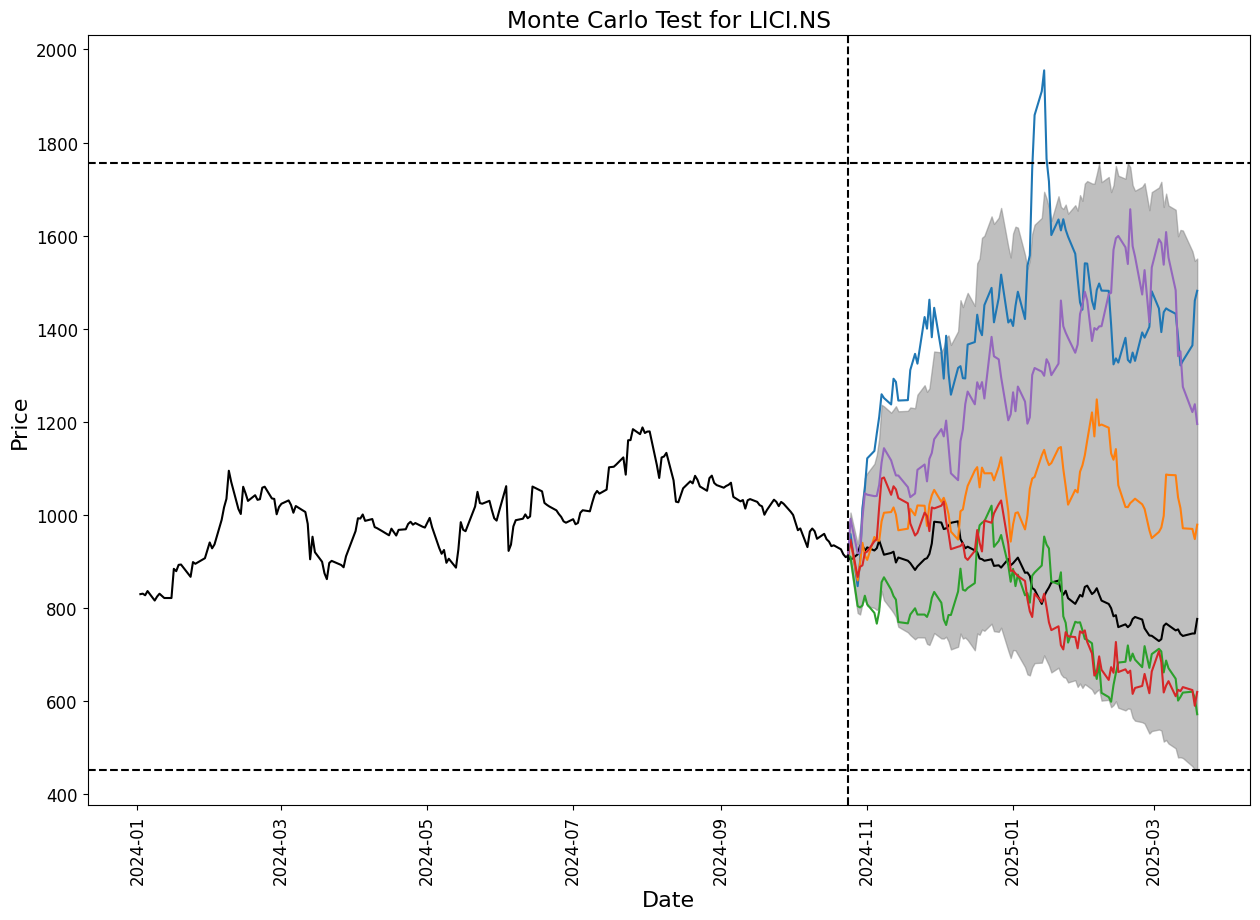

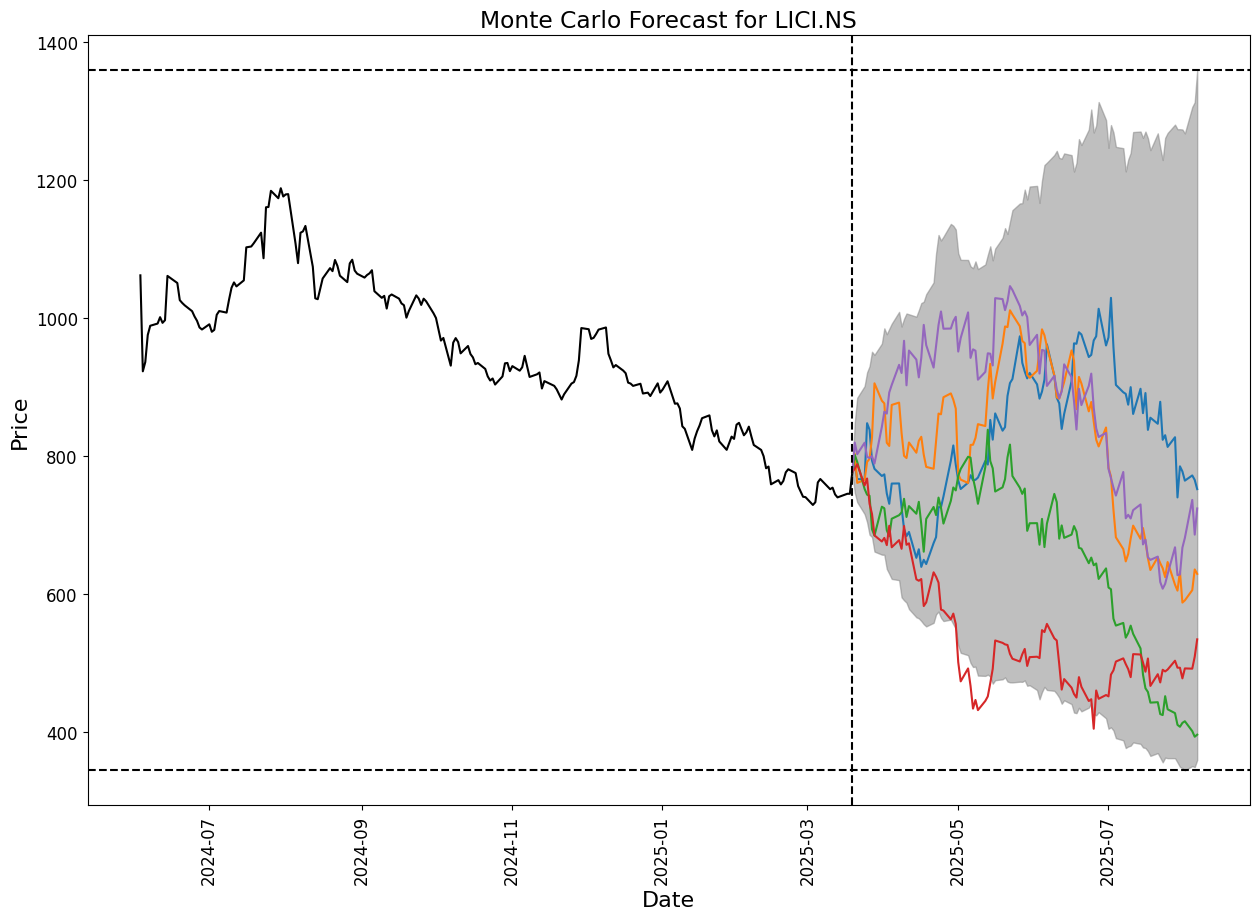

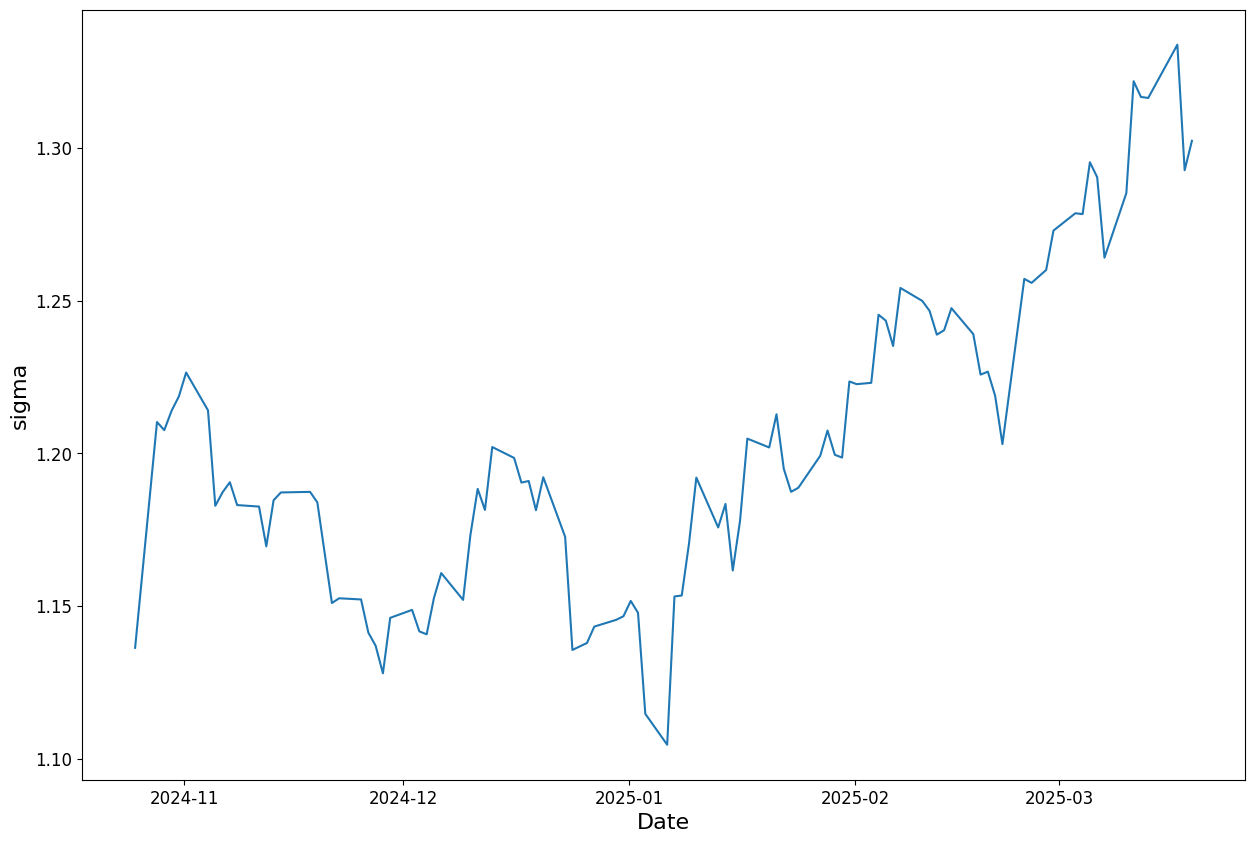

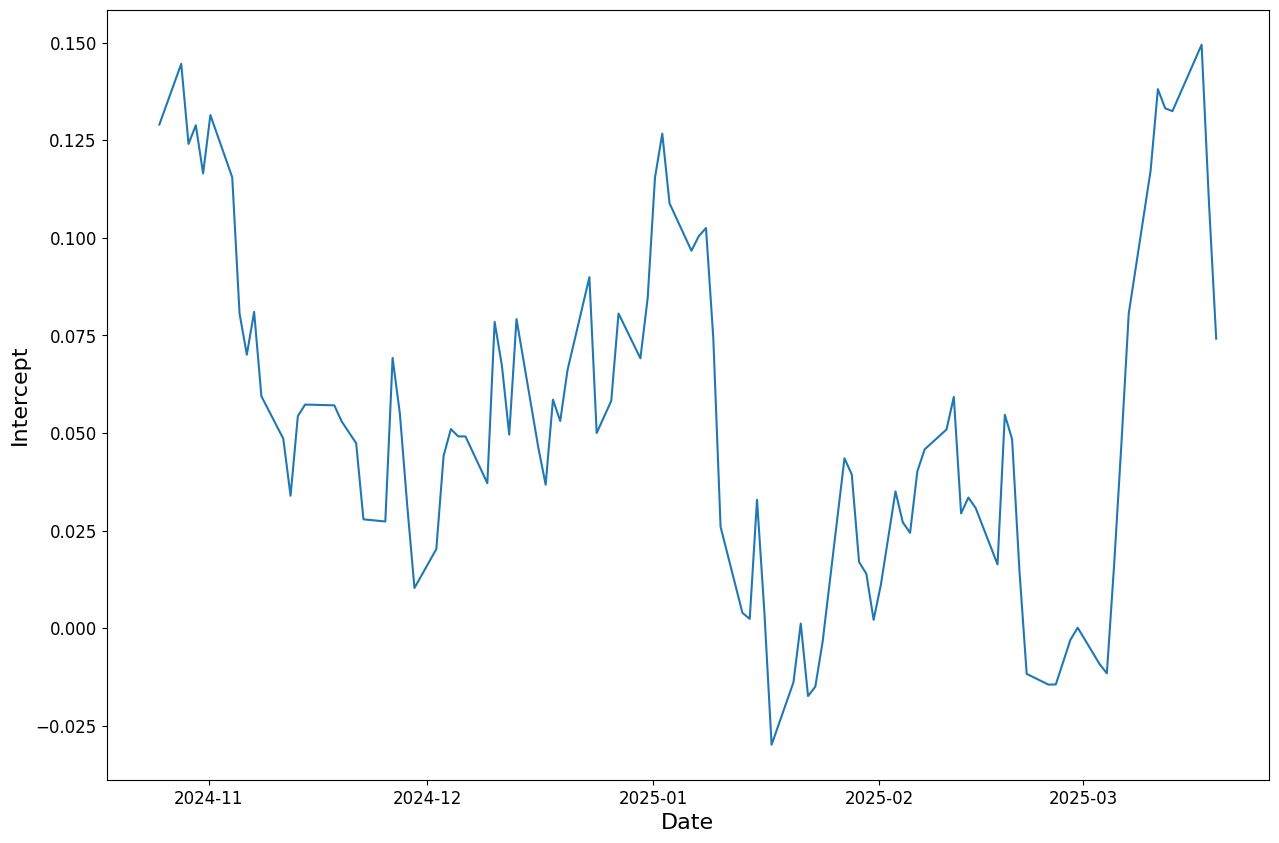

Long Risk Level for 2025-08-06 05:30:00+05:30 is 344.6568993729715 estimated on 2025-03-19 05:30:00+05:30
Short Risk Level for 2025-08-06 05:30:00+05:30 is 1358.896442232914 estimated on 2025-03-19 05:30:00+05:30
Current Price on 2025-03-19 05:30:00+05:30 is 776.75


In [19]:
# Run the complete pipeline for the given ticker
main(ticker)